In [6]:
import geopandas as gpd
import time
import sys,os

root_dir = os.path.abspath(f"..")

def execute(input, boundary):
    # ========== 1. Data Loading ==========
    gdf = gpd.read_file(input)
    boundary = gpd.read_file(boundary)

    print("✅ Data loading completed")
    print("Number of input features:", len(gdf))
    print("Number of clip area features:", len(boundary))


    # ========== 2. CRS Check ==========
    print("\n[CRS Check]")
    print("Input data CRS:", gdf.crs)
    print("Clip data CRS:", boundary.crs)

    if gdf.crs != boundary.crs:
        print("⚠️ CRS mismatch, reprojecting ...")
        boundary = boundary.to_crs(gdf.crs)


    # ========== 3. Geometry Complexity Analysis ==========
    print("\n[Geometry Complexity]")
    print("Geometry type distribution:\n", gdf.geometry.type.value_counts())

    # Average length/area
    print("Average length:", gdf.length.mean())
    print("Average area:", gdf.area.mean())

    # Clip area complexity
    boundary_vertices = sum(
        len(geom.exterior.coords) 
        for geom in boundary.geometry if geom.geom_type == "Polygon"
    )
    print("Total number of vertices in clip area:", boundary_vertices)


    # ========== 4. Spatial Index ==========
    print("\n[Spatial Index]")
    sindex = gdf.sindex
    print("Index type:", type(sindex))
    print("Number of geometries in index:", len(sindex))


    # ========== 5. Bounding Box Filter Effect ==========
    bbox = boundary.total_bounds  # [xmin, ymin, xmax, ymax]
    gdf_small = gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    print("\n[Bounding Box Filter]")
    print("Before filter:", len(gdf), "After filter:", len(gdf_small))


    # ========== 6. Clip Performance Test ==========
    print("\n[Clip Performance Test]")
    start = time.time()
    clipped = gpd.clip(gdf_small, boundary)
    print("Clip time:", round(time.time() - start, 2), "seconds")
    print("Number of result features:", len(clipped))


    # ========== 7. Memory Usage ==========
    print("\n[Memory Usage]")
    print("Input data size:", sys.getsizeof(gdf), "bytes")
    print("Result data size:", sys.getsizeof(clipped), "bytes")


In [ ]:
execute(f'{root_dir}/test-data/lds-nz-lake-polygons-topo-150k-SHP/nz-lake-polygons-topo-150k.shp', 
        f'{root_dir}/output-data/district.shp')

In [7]:
execute(f'{root_dir}/test-data/lds-nz-river-centrelines-topo-150k-SHP/nz-river-centrelines-topo-150k.shp', 
        f'{root_dir}/output-data/district.shp')

✅ Data loading completed
Number of input features: 711933
Number of clip area features: 1

[CRS Check]
Input data CRS: EPSG:2193
Clip data CRS: EPSG:2193

[Geometry Complexity]
Geometry type distribution:
 LineString    711933
Name: count, dtype: int64
Average length: 706.8492199016052
Average area: 0.0
Total number of vertices in clip area: 0

[Spatial Index]
Index type: <class 'geopandas.sindex.SpatialIndex'>
Number of geometries in index: 711933

[Bounding Box Filter]
Before filter: 711933 After filter: 21436

[Clip Performance Test]
Clip time: 1053.46 seconds
Number of result features: 17315

[Memory Usage]
Input data size: 8543360 bytes
Result data size: 346332 bytes


In [4]:
import geopandas as gpd
import pandas as pd
import time
import sys,os

root_dir = os.path.abspath(f"..")
all_lake_shp = f'{root_dir}/test-data/lds-nz-lake-polygons-topo-150k-SHP/nz-lake-polygons-topo-150k.shp'
district_shp=f'{root_dir}/output-data/district.shp'

# ========== 1. Data Loading ==========
gdf = gpd.read_file(all_lake_shp)
boundary = gpd.read_file(district_shp)

# Reproject if needed
if gdf.crs != boundary.crs:
    boundary = boundary.to_crs(gdf.crs)

# Optional: simplify the clipping geometry first
# boundary_simplified = boundary.simplify(tolerance=50, preserve_topology=True)
boundary_simplified = boundary

# ========== 2. Chunk Processing Parameters ==========
chunk_size = 5000  # Number of features per chunk, adjust according to memory
num_chunks = (len(gdf) // chunk_size) + 1

clipped_chunks = []

start_total = time.time()
for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(gdf))
    gdf_chunk = gdf.iloc[start_idx:end_idx]
    
    # Optional: coarse filter with bbox first
    bbox = boundary_simplified.total_bounds
    gdf_chunk = gdf_chunk.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    
    # clip
    start_chunk = time.time()
    clipped_chunk = gpd.clip(gdf_chunk, boundary_simplified)
    elapsed_chunk = round(time.time() - start_chunk, 2)
    
    print(f"Chunk {i+1}/{num_chunks} | Number of features: {len(gdf_chunk)} | Clip time: {elapsed_chunk}s | Result features: {len(clipped_chunk)}")
    
    clipped_chunks.append(clipped_chunk)

# ========== 3. Merge Results ==========
clipped_final = pd.concat(clipped_chunks, ignore_index=True)

end_total = time.time()
print(f"\nTotal clip time: {round(end_total - start_total, 2)} seconds")
print("Total number of result features:", len(clipped_final))


Chunk 1/13 | Number of features: 54 | Clip time: 2.76s | Result features: 47
Chunk 2/13 | Number of features: 0 | Clip time: 0.0s | Result features: 0
Chunk 3/13 | Number of features: 0 | Clip time: 0.0s | Result features: 0
Chunk 4/13 | Number of features: 0 | Clip time: 0.0s | Result features: 0
Chunk 5/13 | Number of features: 21 | Clip time: 1.58s | Result features: 21
Chunk 6/13 | Number of features: 28 | Clip time: 1.83s | Result features: 28
Chunk 7/13 | Number of features: 0 | Clip time: 0.0s | Result features: 0
Chunk 8/13 | Number of features: 0 | Clip time: 0.0s | Result features: 0
Chunk 9/13 | Number of features: 0 | Clip time: 0.0s | Result features: 0
Chunk 10/13 | Number of features: 23 | Clip time: 1.56s | Result features: 17
Chunk 11/13 | Number of features: 0 | Clip time: 0.0s | Result features: 0
Chunk 12/13 | Number of features: 1975 | Clip time: 75.42s | Result features: 1716
Chunk 13/13 | Number of features: 9 | Clip time: 1.19s | Result features: 8

Total clip t

In [49]:
from shapely import MultiPolygon


district_shp=f'{root_dir}/output-data/district.shp'
boundary = gpd.read_file(district_shp)
mp: MultiPolygon = boundary.geometry.array[0]
len(mp.geoms[0].exterior.coords)
mp.geoms[0].exterior.coords.xy
mp.bounds

(1566500.2767000003, 6052039.7941, 1722153.2516, 6194308.4926)

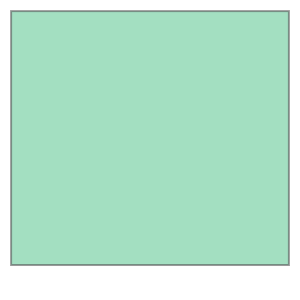

In [ ]:
from shapely import box
from shapely.geometry import Polygon

# get new boundary from old boundary, just keep a minimum rectangle that can contain all old boundary
minx, miny, maxx, maxy = boundary.total_bounds
bbox = box(minx, miny, maxx, maxy)   # shapely 生成矩形 Polygon

# 3. 生成新的 GeoDataFrame
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs=boundary.crs)
bbox_gdf.geometry[0]

# bbox_gdf.to_file("city_bbox.shp")